In [1]:
from langgraph.graph import StateGraph , END, START

from typing import TypedDict, Annotated
from langchain_core.messages import BaseMessage, HumanMessage
from langgraph.graph.message import add_messages

from langchain_openai import ChatOpenAI

from langgraph.prebuilt import ToolNode, tools_condition
from langchain_community.tools import TavilySearchResults
from langchain_core.tools import tool

import requests
import random


from dotenv import load_dotenv
load_dotenv()

True

In [2]:
llm = ChatOpenAI()

In [3]:
search_tool = TavilySearchResults(max_results=3, search_depth="advanced")

In [4]:
@tool

def calculator(first_num : float, second_num : float, operation :str) -> dict:
     """
    Perform a basic arithmetic operation on two numbers.
    Supported operations: add, sub, mul, div
    """
     try:
        if operation == "add":
            result = first_num + second_num

        elif operation == "sub":
            result = first_num - second_num

        elif operation == "mul":
            result = first_num * second_num

        elif operation == "div":
            if second_num == 0:
                return {"error": "Division by zero is not allowed"}
            
            result = first_num / second_num

        else:
            return {"error": f"Unsupported operation '{operation}'"}
        
        return {"first_num": first_num, "second_num": second_num, "operation": operation, "result": result}

     except Exception as e:
         return {"error": str(e)}
     

@tool

def get_stock_price(symbol : str) -> dict:
    """
    Fetch latest stock price for a given symbol (e.g. 'AAPL', 'TSLA') 
    using Alpha Vantage with API key in the URL.
    """

    url = f"https://www.alphavantage.co/query?function=GLOBAL_QUOTE&symbol={symbol}&apikey=C9PE94QUEW9VWGFM"

    r = requests.get(url)
    return r.json()


In [5]:
tools = [get_stock_price, search_tool, calculator]

In [6]:
llm_with_tools = llm.bind_tools(tools)

In [7]:
class ChatState(TypedDict):
    messages : Annotated[list[BaseMessage], add_messages]

In [9]:
def chat_node(state: ChatState):
    """LLM node that may answer or request a tool call."""
    messages = state['messages']
    response = llm_with_tools.invoke(messages)
    return {"messages":[response]}

tool_node = ToolNode(tools)

In [13]:
graph = StateGraph(ChatState)

graph.add_node("chat_node", chat_node)
graph.add_node("tools", tool_node)


graph.add_edge(START, "chat_node")

graph.add_conditional_edges("chat_node",tools_condition) ##tools condition helps you route automatically

graph.add_edge("tools", "chat_node")


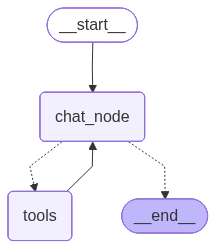

In [14]:
graph.compile()

In [15]:
chatbot = graph.compile()

In [16]:
out = chatbot.invoke({"messages": [HumanMessage(content = "hello!")]})
print (out)

{'messages': [HumanMessage(content='hello!', additional_kwargs={}, response_metadata={}, id='cff2edd9-5f24-41f2-9d15-8f427478ba63'), AIMessage(content='Hello! How can I assist you today?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 10, 'prompt_tokens': 177, 'total_tokens': 187, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-3.5-turbo-0125', 'system_fingerprint': None, 'finish_reason': 'stop', 'logprobs': None}, id='run--90e9b78d-0c30-4c44-a959-e64b30f0fc23-0', usage_metadata={'input_tokens': 177, 'output_tokens': 10, 'total_tokens': 187, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}})]}


In [19]:
print (out['messages'][-1].content)

Hello! How can I assist you today?


In [20]:
out = chatbot.invoke({"messages": [HumanMessage(content="What is 2*3?")]})
print(out["messages"][-1].content)

The result of 2 * 3 is 6.


In [21]:
out

{'messages': [HumanMessage(content='What is 2*3?', additional_kwargs={}, response_metadata={}, id='099c4f58-80ea-40bf-8f0f-2381973083be'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_c2tY5W2lRpwYJayKXEqryonB', 'function': {'arguments': '{"first_num":2,"operation":"mul","second_num":3}', 'name': 'calculator'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 24, 'prompt_tokens': 182, 'total_tokens': 206, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-3.5-turbo-0125', 'system_fingerprint': None, 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--922310dd-56a8-4aad-a8eb-f05a685d30b5-0', tool_calls=[{'name': 'calculator', 'args': {'first_num': 2, 'operation': 'mul', 'second_num': 3}, 'id': 'call_c2tY5W2lRpwYJayKXEqryonB', 'type': 'too

In [22]:
out2 = chatbot.invoke({"messages": [HumanMessage(content="What is the stock price of apple")]})
print(out2["messages"][-1].content)

The latest stock price of Apple (AAPL) is $229.72.


In [30]:
out2['messages'][3]

AIMessage(content='The latest stock price of Apple (AAPL) is $229.72.', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 17, 'prompt_tokens': 325, 'total_tokens': 342, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-3.5-turbo-0125', 'system_fingerprint': None, 'finish_reason': 'stop', 'logprobs': None}, id='run--ba40faaa-524b-41c9-b106-fdef8883f593-0', usage_metadata={'input_tokens': 325, 'output_tokens': 17, 'total_tokens': 342, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}})

In [ ]:
# Chat requiring tool
out3 = chatbot.invoke({"messages": [HumanMessage(content="First find out the stock price of Apple using get stock price tool then use the calculator tool to find out how much will it take to purchase 50 shares?")]})
print(out3["messages"][-1].content)